✅ torch_geometric_temporal 加载成功！
使用的设备: cuda

>>> [Step 1] Loading and Splitting Data...
✅ PyG Data Loaded: 46564 nodes.
>>> Generating 49 temporal snapshots...
✅ Splitting Complete.

>>> [Step 2] Creating Temporal Signal...
✅ TGT Dataset Ready.

>>> [Step 3] Training EvolveGCN (Rolling Mode)...
Starting training...


C:\Users\zhj\AppData\Local\Temp\ipykernel_31928\3325248302.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(snapshot.x).to(device)
C:\Users\zhj\AppData\Local\Temp\ipykernel_31928\3325248302.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(snapshot.edge_index).to(device)
C:\Users\zhj\AppData\Local\Temp\ipykernel_31928\3325248302.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(snapshot.y).long().to(device)


Epoch 10 | Avg Train Loss: 0.2148
Epoch 20 | Avg Train Loss: 0.1532
Epoch 30 | Avg Train Loss: 0.1355
Epoch 40 | Avg Train Loss: 0.1220
Epoch 50 | Avg Train Loss: 0.1171

✅ EvolveGCN Test AUC: 0.8403

📊 Evaluation at Default Threshold (0.5):
  - Accuracy:  0.9501
  - Precision: 0.8014
  - Recall:    0.3093
  - F1-Score:  0.4464

🚀 Evaluation at Optimal Threshold (0.14):
  - Accuracy:  0.9490
  - Precision: 0.6492
  - Recall:    0.4681
  - F1-Score:  0.5440 (Maximized)

Confusion Matrix (Best Th):
[[15313   274]
 [  576   507]]

>>> 生成 EvolveGCN 诊断图表...


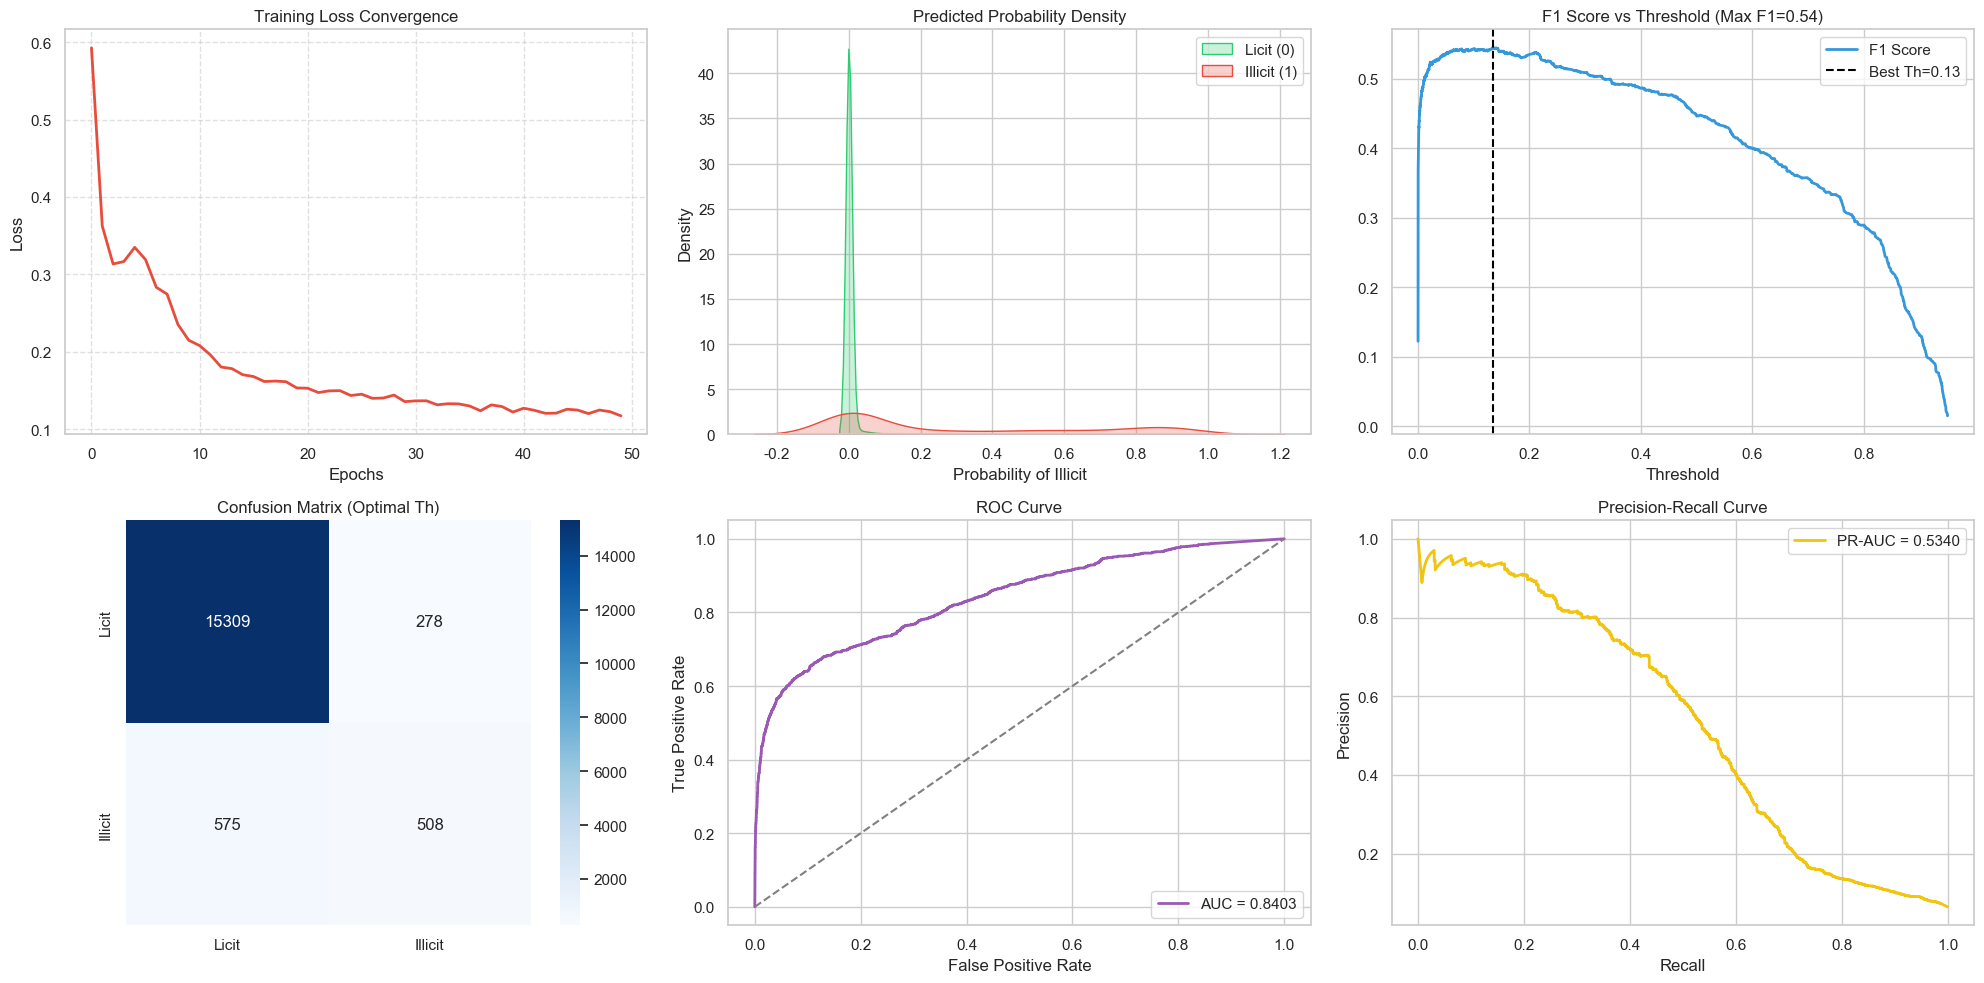


>>> [Step 4] Training RF & Building Hybrid Model...
Alpha (RF Wt)   | F1-Score  
------------------------------
0.00            | 0.5415
0.10            | 0.6822
0.20            | 0.7118
0.30            | 0.7300
0.40            | 0.7429
0.50            | 0.7552
0.60            | 0.7636
0.70            | 0.7723
0.80            | 0.7778
0.90            | 0.7930
1.00            | 0.8144
------------------------------
🏆 Best Hybrid F1: 0.8144 (Alpha=1.00)

>>> [Step 6] Analyzing Temporal Stability of EvolveGCN...
使用的分类阈值 (Threshold): 0.1339


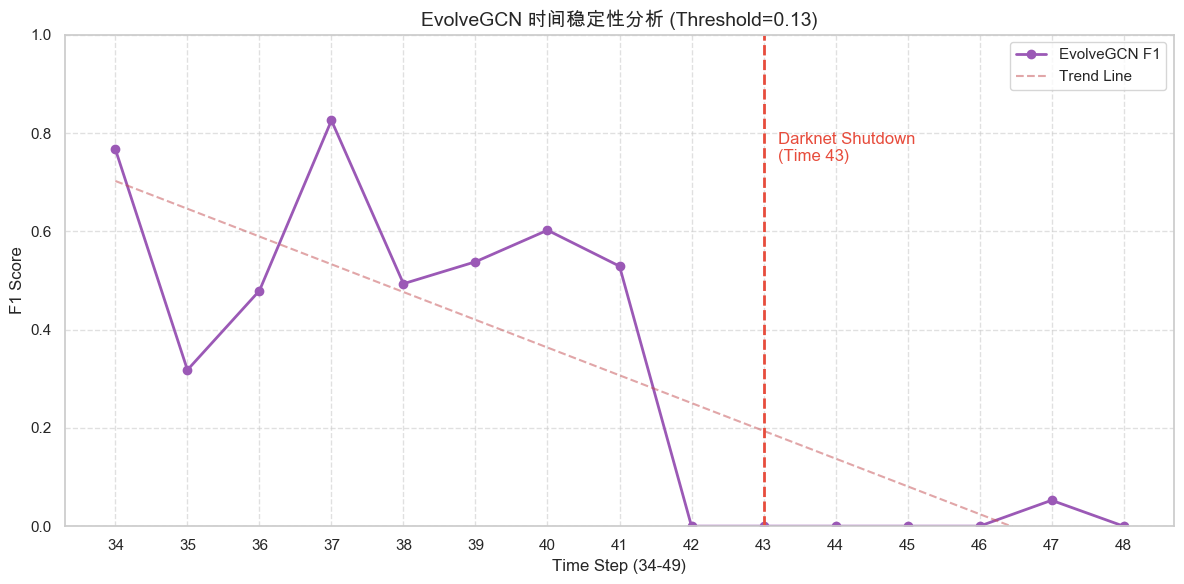

平均 F1: 0.3070
F1 标准差 (波动程度): 0.3017
Time 43 表现: 0.0000


In [1]:
# ==============================================================================
# 09_EvolveGCN_Hybrid_TGT.ipynb
# 基于 torch_geometric_temporal 的标准实现 (环境已修复版)
# ==============================================================================

import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 设置绘图风格
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 引入 TGT 库 (如果这里报错，请先重启 Kernel)
try:
    from torch_geometric_temporal.nn.recurrent import EvolveGCNO
    from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
    print("✅ torch_geometric_temporal 加载成功！")
except ImportError:
    raise ImportError("请重启 Jupyter Kernel 后再运行此代码。")

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用的设备: {device}")

# ==============================================================================
# 1. 精细化数据切分 (Snapshot Splitting)
# ==============================================================================
print("\n>>> [Step 1] Loading and Splitting Data...")

# 路径配置 (请确认路径正确)
PYG_DATA_PATH = '../data/processed/elliptic_pyg.pt'
RAW_FEATURES_PATH = '../data/raw/elliptic_txs_features.csv'
RAW_CLASSES_PATH = '../data/raw/elliptic_txs_classes.csv'

# 1.1 加载 PyG 完整数据
try:
    data_all = torch.load(PYG_DATA_PATH, weights_only=False)
    print(f"✅ PyG Data Loaded: {data_all.num_nodes} nodes.")
except FileNotFoundError:
    raise FileNotFoundError(f"找不到文件 {PYG_DATA_PATH}，请检查路径。")

# 1.2 加载原始 CSV 用于获取时间步信息
df_classes = pd.read_csv(RAW_CLASSES_PATH)
df_features = pd.read_csv(RAW_FEATURES_PATH, header=None, usecols=[0, 1], names=['txId', 'time_step'])
df_merged = pd.merge(df_features, df_classes, on='txId', how='left')

# 过滤掉 Unknown，只保留 '1' 和 '2'
df_labeled = df_merged[df_merged['class'] != 'unknown'].copy()

# 验证对齐
if len(df_labeled) != data_all.num_nodes:
    raise ValueError(f"数据不匹配! PyG: {data_all.num_nodes}, CSV: {len(df_labeled)}")

# 1.3 开始切分
time_counts = df_labeled.groupby('time_step').size().sort_index()
snapshots_x = []
snapshots_y = []
snapshots_edge_index = []

current_idx = 0
edge_index_all = data_all.edge_index

print(">>> Generating 49 temporal snapshots...")

for t in time_counts.index: # Time 1 to 49
    count = time_counts[t]

    # 提取特征和标签
    x_t = data_all.x[current_idx : current_idx + count]
    y_t = data_all.y[current_idx : current_idx + count]

    # 提取边 (仅保留当前时间步内部的边)
    mask = (edge_index_all[0] >= current_idx) & (edge_index_all[0] < current_idx + count) & \
           (edge_index_all[1] >= current_idx) & (edge_index_all[1] < current_idx + count)

    edge_index_t = edge_index_all[:, mask]
    edge_index_t = edge_index_t - current_idx # 重映射索引

    snapshots_x.append(x_t.numpy())
    snapshots_y.append(y_t.numpy())
    snapshots_edge_index.append(edge_index_t.numpy())

    current_idx += count

print("✅ Splitting Complete.")

# ==============================================================================
# 2. 构建 TGT 数据集
# ==============================================================================
print("\n>>> [Step 2] Creating Temporal Signal...")

# Elliptic 没有边权重，设为 None
snapshots_edge_weights = [None for _ in range(len(snapshots_x))]

dataset = DynamicGraphTemporalSignal(
    edge_indices=snapshots_edge_index,
    edge_weights=snapshots_edge_weights,
    features=snapshots_x,
    targets=snapshots_y
)

print("✅ TGT Dataset Ready.")

# ==============================================================================
# 3. 定义 EvolveGCN 模型 (修复版：适配 TGT 库接口)
# ==============================================================================
class EvolveGCN_Model(torch.nn.Module):
    def __init__(self, node_features, hidden_dim):
        super(EvolveGCN_Model, self).__init__()

        # 1. 预处理层：先将高维特征(165)降维到隐藏层(128)
        # 这样做的目的是为了适配 EvolveGCNO (它要求输入输出维度一致)
        self.preprocess = torch.nn.Linear(node_features, hidden_dim)

        # 2. 演化层：EvolveGCN-O
        # 注意：这里只需要 in_channels，不需要 out_channels
        self.recurrent = EvolveGCNO(in_channels=hidden_dim,
                                    improved=True,
                                    cached=True)

        # 3. 分类层
        self.linear = torch.nn.Linear(hidden_dim, 2)

    def forward(self, x, edge_index):
        # Step A: 降维
        x = self.preprocess(x)
        x = F.relu(x)

        # Step B: 动态演化 (输入128 -> 输出128)
        h = self.recurrent(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)

        # Step C: 分类
        h = self.linear(h)
        return h

# ==============================================================================
# 4. 训练 EvolveGCN 并全面评估 (Accuracy, Precision, Recall, F1)
# ==============================================================================

print("\n>>> [Step 3] Training EvolveGCN (Rolling Mode)...")

# 1. 初始化
model = EvolveGCN_Model(node_features=data_all.num_features, hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
class_weights = torch.tensor([0.3, 0.7]).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

TRAIN_RANGE = range(34)
TEST_RANGE = range(34, 49)

# 记录器
history = {'loss': [], 'f1_train': []}
gnn_preds_list = []
gnn_labels_list = []

print("Starting training...")

for epoch in range(50):
    model.train()
    loss_epoch = 0

    # Rolling Training
    for t, snapshot in enumerate(dataset):
        x = torch.tensor(snapshot.x).to(device)
        edge_index = torch.tensor(snapshot.edge_index).to(device)
        y = torch.tensor(snapshot.y).long().to(device)

        if t in TRAIN_RANGE:
            optimizer.zero_grad()
            y_hat = model(x, edge_index)
            loss = criterion(y_hat, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            # Detach
            model.recurrent.weight = model.recurrent.weight.detach()
            loss_epoch += loss.item()

        elif t in TEST_RANGE and epoch == 49:
            model.eval()
            with torch.no_grad():
                y_hat = model(x, edge_index)
                prob = F.softmax(y_hat, dim=1)[:, 1]
                gnn_preds_list.append(prob.cpu().numpy())
                gnn_labels_list.append(y.cpu().numpy())

    model.recurrent.weight = model.recurrent.weight.detach()

    # 记录平均 Loss
    avg_loss = loss_epoch / len(TRAIN_RANGE)
    history['loss'].append(avg_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1:02d} | Avg Train Loss: {avg_loss:.4f}")

# 拼接结果
gnn_probs_all = np.concatenate(gnn_preds_list)
test_labels_all = np.concatenate(gnn_labels_list)

# ==============================================================================
# 结果汇总与多维度指标计算
# ==============================================================================
if len(gnn_preds_list) > 0:
    # 拼接所有时间步的预测结果
    gnn_probs_all = np.concatenate(gnn_preds_list)
    test_labels_all = np.concatenate(gnn_labels_list)

    # --- Metric 1: AUC (衡量排序能力) ---
    gnn_auc = roc_auc_score(test_labels_all, gnn_probs_all)
    print(f"\n✅ EvolveGCN Test AUC: {gnn_auc:.4f}")

    # --- Metric 2: 默认阈值 (0.5) 下的指标 ---
    preds_default = (gnn_probs_all > 0.5).astype(int)
    print(f"\n📊 Evaluation at Default Threshold (0.5):")
    print(f"  - Accuracy:  {accuracy_score(test_labels_all, preds_default):.4f}")
    print(f"  - Precision: {precision_score(test_labels_all, preds_default, pos_label=1, zero_division=0):.4f}")
    print(f"  - Recall:    {recall_score(test_labels_all, preds_default, pos_label=1):.4f}")
    print(f"  - F1-Score:  {f1_score(test_labels_all, preds_default, pos_label=1):.4f}")

    # --- Metric 3: 最佳阈值 (Best F1) 下的指标 ---
    # 神经网络输出的概率可能偏低（例如都在 0.1~0.4），寻找最佳切分点能展示模型的真实分类潜力
    best_th = 0.5
    best_f1 = 0

    # 遍历 0.01 到 0.99 寻找最佳阈值
    for th in np.linspace(0.01, 0.99, 100):
        preds = (gnn_probs_all > th).astype(int)
        f1 = f1_score(test_labels_all, preds, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_th = th

    # 使用最佳阈值计算最终指标
    preds_best = (gnn_probs_all > best_th).astype(int)
    print(f"\n🚀 Evaluation at Optimal Threshold ({best_th:.2f}):")
    print(f"  - Accuracy:  {accuracy_score(test_labels_all, preds_best):.4f}")
    print(f"  - Precision: {precision_score(test_labels_all, preds_best, pos_label=1, zero_division=0):.4f}")
    print(f"  - Recall:    {recall_score(test_labels_all, preds_best, pos_label=1):.4f}")
    print(f"  - F1-Score:  {best_f1:.4f} (Maximized)")

    # 打印混淆矩阵
    cm = confusion_matrix(test_labels_all, preds_best)
    print(f"\nConfusion Matrix (Best Th):\n{cm}")

else:
    print("❌ 警告：未收集到测试集预测结果。")


# ==============================================================================
# 5. 深度可视化诊断 (Diagnostic Visualization)
# ==============================================================================
print("\n>>> 生成 EvolveGCN 诊断图表...")

fig = plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# --- 图 1: 训练 Loss 曲线 ---
ax1 = plt.subplot(2, 3, 1)
ax1.plot(history['loss'], label='Train Loss', color='#e74c3c', linewidth=2)
ax1.set_title('Training Loss Convergence', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True, linestyle='--', alpha=0.6)

# --- 图 2: 预测概率分布 (Probability Distribution) ---
# 这个图能告诉你模型是否“犹豫不决”（概率集中在0.5）还是“自信”（两极分化）
ax2 = plt.subplot(2, 3, 2)
sns.kdeplot(gnn_probs_all[test_labels_all==0], color='#2ecc71', fill=True, label='Licit (0)', ax=ax2)
sns.kdeplot(gnn_probs_all[test_labels_all==1], color='#e74c3c', fill=True, label='Illicit (1)', ax=ax2)
ax2.set_title('Predicted Probability Density', fontsize=12, fontweight='bold')
ax2.set_xlabel('Probability of Illicit')
ax2.legend()

# --- 图 3: 最佳阈值搜索 (F1 vs Threshold) ---
ax3 = plt.subplot(2, 3, 3)
precisions, recalls, thresholds = precision_recall_curve(test_labels_all, gnn_probs_all)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
# 找到最佳点
best_idx = np.argmax(f1_scores)
best_th = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

ax3.plot(thresholds, f1_scores[:-1], color='#3498db', linewidth=2, label='F1 Score')
ax3.axvline(best_th, color='black', linestyle='--', label=f'Best Th={best_th:.2f}')
ax3.set_title(f'F1 Score vs Threshold (Max F1={best_f1:.2f})', fontsize=12, fontweight='bold')
ax3.set_xlabel('Threshold')
ax3.legend()

# --- 图 4: 混淆矩阵 (在最佳阈值下) ---
ax4 = plt.subplot(2, 3, 4)
preds_best = (gnn_probs_all > best_th).astype(int)
cm = confusion_matrix(test_labels_all, preds_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4, square=True,
            xticklabels=['Licit', 'Illicit'], yticklabels=['Licit', 'Illicit'])
ax4.set_title('Confusion Matrix (Optimal Th)', fontsize=12, fontweight='bold')

# --- 图 5: ROC 曲线 ---
ax5 = plt.subplot(2, 3, 5)
fpr, tpr, _ = roc_curve(test_labels_all, gnn_probs_all)
roc_auc = auc(fpr, tpr)
ax5.plot(fpr, tpr, color='#9b59b6', lw=2, label=f'AUC = {roc_auc:.4f}')
ax5.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax5.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax5.set_xlabel('False Positive Rate')
ax5.set_ylabel('True Positive Rate')
ax5.legend(loc="lower right")

# --- 图 6: P-R 曲线 ---
ax6 = plt.subplot(2, 3, 6)
pr_auc = auc(recalls, precisions)
ax6.plot(recalls, precisions, color='#f1c40f', lw=2, label=f'PR-AUC = {pr_auc:.4f}')
ax6.set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
ax6.set_xlabel('Recall')
ax6.set_ylabel('Precision')
ax6.legend()

plt.tight_layout()
plt.show()

# ==============================================================================
# 5. 训练 Random Forest (基准) & 混合模型
# ==============================================================================
print("\n>>> [Step 4] Training RF & Building Hybrid Model...")

# 提取对应的 RF 训练/测试数据
X_all = data_all.x.numpy()
y_all = data_all.y.numpy()

split_idx = 0
for t in range(34):
    split_idx += time_counts.iloc[t]

X_train_rf = X_all[:split_idx]
y_train_rf = y_all[:split_idx]
X_test_rf = X_all[split_idx:]
y_test_rf = y_all[split_idx:]

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_rf, y_train_rf)
rf_probs_all = rf.predict_proba(X_test_rf)[:, 1]

# Rank Voting
rank_rf = rankdata(rf_probs_all) / len(rf_probs_all)
rank_gnn = rankdata(gnn_probs_all) / len(gnn_probs_all)

best_f1 = 0
best_alpha = 0

print(f"{'Alpha (RF Wt)':<15} | {'F1-Score':<10}")
print("-" * 30)

for alpha in np.linspace(0, 1, 11):
    final_score = alpha * rank_rf + (1 - alpha) * rank_gnn

    # 简单搜索阈值
    curr_best_f1 = 0
    for th_pct in np.linspace(0.8, 0.99, 20):
        preds = (final_score > th_pct).astype(int)
        f1 = f1_score(y_test_rf, preds, pos_label=1)
        if f1 > curr_best_f1: curr_best_f1 = f1

    if curr_best_f1 > best_f1:
        best_f1 = curr_best_f1
        best_alpha = alpha

    print(f"{alpha:<15.2f} | {curr_best_f1:.4f}")

print("-" * 30)
print(f"🏆 Best Hybrid F1: {best_f1:.4f} (Alpha={best_alpha:.2f})")


# ==============================================================================
# 6. EvolveGCN 时间稳定性深度分析 (Temporal Robustness)
# ==============================================================================
print("\n>>> [Step 6] Analyzing Temporal Stability of EvolveGCN...")

# 1. 准备数据
# TEST_RANGE 是 range(34, 49)，直接对应 gnn_preds_list 的索引
time_steps = list(range(34, 49))
evolve_f1_scores = []

# 确保我们使用之前计算出的"最佳阈值"，如果没有则默认 0.5
# best_th 应该在之前的 Step 5 中计算过了
current_th = best_th if 'best_th' in locals() else 0.5
print(f"使用的分类阈值 (Threshold): {current_th:.4f}")

# 2. 逐个时间步计算 F1
for i, t in enumerate(time_steps):
    # 取出当前时间步的预测概率和真实标签
    # gnn_preds_list 是按时间顺序 append 的，所以直接索引即可
    probs_t = gnn_preds_list[i]
    labels_t = gnn_labels_list[i]

    # 进行预测
    preds_t = (probs_t > current_th).astype(int)

    # 计算 F1 (注意处理分母为0的情况，虽然后期时间步通常都有正样本)
    if np.sum(labels_t) > 0:
        f1 = f1_score(labels_t, preds_t, pos_label=1)
    else:
        f1 = 0.0 # 该时间步没有黑产样本

    evolve_f1_scores.append(f1)
    # print(f"Time {t}: F1 = {f1:.4f}") #哪怕打印出来看看也好

# 3. 绘制稳定性曲线 (模仿文件 11 的风格)
plt.figure(figsize=(12, 6))

# 绘制折线
plt.plot(time_steps, evolve_f1_scores, marker='o', linewidth=2, color='#9b59b6', label='EvolveGCN F1')

# 添加趋势线 (可选，看整体是上升还是下降)
z = np.polyfit(time_steps, evolve_f1_scores, 1)
p = np.poly1d(z)
plt.plot(time_steps, p(time_steps), "r--", alpha=0.5, label='Trend Line')

# 标记关键事件：Time 43 (暗网关闭)
plt.axvline(x=43, color='#e74c3c', linestyle='--', linewidth=2)
plt.text(43.2, max(evolve_f1_scores)*0.9, 'Darknet Shutdown\n(Time 43)', color='#e74c3c', fontweight='bold')

# 装饰
plt.title(f'EvolveGCN 时间稳定性分析 (Threshold={current_th:.2f})', fontsize=14, fontweight='bold')
plt.xlabel('Time Step (34-49)', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.ylim(0, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.xticks(time_steps) # 强制显示所有时间步刻度

plt.tight_layout()
plt.show()

# 4. 简要统计
print(f"平均 F1: {np.mean(evolve_f1_scores):.4f}")
print(f"F1 标准差 (波动程度): {np.std(evolve_f1_scores):.4f}")
print(f"Time 43 表现: {evolve_f1_scores[time_steps.index(43)]:.4f}")